##### Model selection for Lasso models that are Linear models with an L1 penalty for regression problems.

Indeed, several strategies can be used to select the value of the regularization parameter
* cross-validation
* using an information criterion, namely AIC or BIC.

In [72]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)

X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In addition, we add some random features to the original data to better illustrate the feature selection performed by the Lasso model.

In [73]:
import numpy as np
import pandas as pd


rng = np.random.RandomState(42)
num_random_features = 14
#  floating-point samples from the standard normal distribution
X_random = pd.DataFrame(data=rng.randn(X.shape[0], num_random_features),
                        columns=[f'random-{i}' for i in range(num_random_features)])
# X_random.shape --> (442, 14)
X = pd.concat([X, X_random], axis=1)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,random-4,random-5,random-6,random-7,random-8,random-9,random-10,random-11,random-12,random-13
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,...,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,...,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,...,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.738467,0.171368
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,...,-0.460639,1.057122,0.343618,-1.763040,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,...,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120


Selecting Lasso via an information criterion
LassoLarsIC provides a Lasso estimator that uses the Akaike information criterion (AIC) or the Bayes information criterion (BIC) to select the optimal value of the regularization parameter alpha.

Before fitting the model, we will standardize the data with a StandardScaler. 

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import StandardScaler

In [75]:
%%time
pipe = make_pipeline(StandardScaler(), LassoLarsIC(criterion='aic', normalize=False))
pipe.fit(X,y)

CPU times: total: 15.6 ms
Wall time: 15.6 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassolarsic', LassoLarsIC(normalize=False))])

In [76]:
# The value of the information criteria (‘aic’, ‘bic’) across all alphas.
# The alpha which has the smallest information criterion is chosen

alpha_aic = pipe[1].alpha_

In [77]:
lasso_lars_ic = pd.DataFrame(data={'alphas':pipe[-1].alphas_, 'AIC-criterion':pipe[-1].criterion_}).set_index('alphas')

In [78]:
pipe.set_params(lassolarsic__criterion='bic')
pipe.fit(X,y)

lasso_lars_ic['BIC-criterion']=pipe[-1].criterion_

alpha_bic = pipe[-1].alpha_

##### The value of the information criteria (‘aic’, ‘bic’) across all alphas. The alpha which has the smallest information criterion is chosen

In [79]:
def higlight_min(result):
    minimum = result.min()
    return ['color:red' if val==minimum else 'color:grey' for val in result ]

In [80]:
lasso_lars_ic.style.apply(higlight_min)

,AIC-criterion,BIC-criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5208.250639,5212.341949
21.542052,4928.018900,4936.201520
15.034077,4869.678359,4881.952289
6.189631,4815.437362,4831.802601
5.329616,4810.423641,4830.880191
4.306012,4803.573491,4828.121351
4.124225,4804.126502,4832.765671
3.820705,4803.621645,4836.352124


In [81]:
# check
lasso_lars_ic.min()

AIC-criterion    4794.238744
BIC-criterion    4828.121351
dtype: float64

### PLOTS

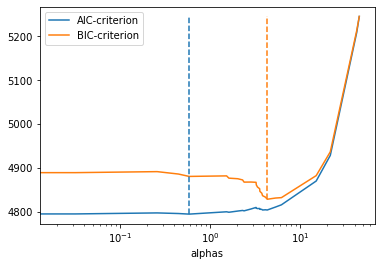

In [99]:
import matplotlib.pyplot as plt

ax = lasso_lars_ic.plot()


y_min = lasso_lars_ic['AIC-criterion'].min()
y_max = lasso_lars_ic['AIC-criterion'].max()

ax.vlines(
    alpha_aic,
    y_min,
    y_max,
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)


y_min = lasso_lars_ic['BIC-criterion'].min()
y_max = lasso_lars_ic['BIC-criterion'].max()

ax.vlines(
    alpha_bic,
    y_min,
    y_max,
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:orange",
)

ax.set_xscale('log')

Model selection with an information-criterion is very fast. It relies on computing the criterion on the in-sample set provided to fit. Both criteria estimate the model generalization error based on the training set error and penalize this overly optimistic error. However, this penalty relies on a proper estimation of the degrees of freedom and the noise variance. Both are derived for large samples (asymptotic results) and assume the model is correct, i.e. that the data are actually generated by this model.

These models also tend to break when the problem is badly conditioned (more features than samples). It is then required to provide an estimate of the noise variance.